In [133]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import pydotplus 
from IPython.display import Image
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate

import seaborn as sn

sn.set_theme()

In [107]:
%%time
datasetPath = "../dataset/users_clean_with_indicators_no_outliers.h5"
df_users = pd.read_hdf(datasetPath)

CPU times: user 72.3 ms, sys: 26.2 ms, total: 98.4 ms
Wall time: 102 ms


<timed exec>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


In [3]:
df_users

,name,lang,bot,created_at,statuses_count,tweet_count,retweet_made_ratio,reply_count_avg,favorite_count_avg,tweet_length_avg,num_special_chars_avg,elapsed_time_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_urls_entropy,num_mentions_entropy,tweet_length_entropy
2353593986,lamonica raborn,en,1,2019-02-22 18:00:42,76,120,0.000000,0.0,0.041667,62.366667,3.958333,1.364257,0.0,0.173205,0.304947,0.000000,0.603637,4.274598
2358850842,lourie botton,en,0,2019-02-26 03:02:32,54,104,0.000000,0.0,0.057692,69.961538,3.615385,1.335474,0.0,0.220570,0.130708,0.000000,0.656454,4.129301
137959629,dadan syarifudin,en,1,2015-04-30 07:09:56,3,3,0.000000,0.0,0.000000,17.333333,4.333333,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,1.098612
466124818,carletto focia,it,1,2017-01-18 02:49:18,50,1275,0.004706,0.0,0.189020,88.509804,4.814118,4.130876,0.0,0.508540,0.252911,0.117266,0.036302,4.686233
2571493866,mbk ebook,en,0,2019-06-18 19:30:21,7085,3277,0.000000,0.0,0.064693,73.673482,3.671651,2.868727,0.0,0.243648,0.402308,0.007320,0.873255,4.765100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911861962,madrid lae maika .,en,0,2019-11-29 13:16:02,1126,1017,0.328417,0.0,0.060964,53.143559,5.085546,2.327531,0.0,0.229384,0.546803,0.126738,1.086588,4.701245
1378532629,clau sato,en,0,2018-04-27 03:01:58,3024,1888,0.106462,0.0,0.227225,60.895127,4.360699,3.268229,0.0,0.586425,0.395943,0.326282,0.964965,4.768169
126984069,alma leticia nuño,es,0,2015-03-29 17:01:24,6,6,0.000000,0.0,0.000000,67.666667,6.666667,1.332179,0.0,0.000000,0.636514,0.636514,0.636514,1.791759
2383025796,minnie guadagno,en,1,2019-03-13 02:44:13,42,96,0.000000,0.0,0.083333,64.572917,3.979167,1.256998,0.0,0.286836,0.057908,0.000000,0.671286,4.120230


In [108]:
df_users['bot'].value_counts(True)

1    0.531456
0    0.468544
Name: bot, dtype: float64

# Discretization phase

In [5]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [46]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
features_to_discretize = ['lang']
df_users_classif = discretize_data(df_users, features_to_discretize)
df_users_classif['created_at'] = df_users_classif.created_at.values.astype(np.int64)

In [47]:
df_users_classif.head(5)

,name,lang,bot,created_at,statuses_count,tweet_count,retweet_made_ratio,reply_count_avg,favorite_count_avg,tweet_length_avg,num_special_chars_avg,elapsed_time_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_urls_entropy,num_mentions_entropy,tweet_length_entropy,lang_num
2353593986,lamonica raborn,en,1,1550858442000000000,76,120,0.000000,0.0,0.041667,62.366667,3.958333,1.364257,0.0,0.173205,0.304947,0.000000,0.603637,4.274598,4
2358850842,lourie botton,en,0,1551150152000000000,54,104,0.000000,0.0,0.057692,69.961538,3.615385,1.335474,0.0,0.220570,0.130708,0.000000,0.656454,4.129301,4
137959629,dadan syarifudin,en,1,1430377796000000000,3,3,0.000000,0.0,0.000000,17.333333,4.333333,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,1.098612,4
466124818,carletto focia,it,1,1484707758000000000,50,1275,0.004706,0.0,0.189020,88.509804,4.814118,4.130876,0.0,0.508540,0.252911,0.117266,0.036302,4.686233,9
2571493866,mbk ebook,en,0,1560886221000000000,7085,3277,0.000000,0.0,0.064693,73.673482,3.671651,2.868727,0.0,0.243648,0.402308,0.007320,0.873255,4.765100,4


In [48]:
#drop the categorical variables since we don't need them anymore
features_to_drop = ['lang', 'name']
df_users_classif.drop(columns=features_to_drop, axis=1, inplace=True)

In [49]:
df_users_classif.head(5)

,bot,created_at,statuses_count,tweet_count,retweet_made_ratio,reply_count_avg,favorite_count_avg,tweet_length_avg,num_special_chars_avg,elapsed_time_entropy,reply_count_entropy,favorite_count_entropy,num_hashtags_entropy,num_urls_entropy,num_mentions_entropy,tweet_length_entropy,lang_num
2353593986,1,1550858442000000000,76,120,0.000000,0.0,0.041667,62.366667,3.958333,1.364257,0.0,0.173205,0.304947,0.000000,0.603637,4.274598,4
2358850842,0,1551150152000000000,54,104,0.000000,0.0,0.057692,69.961538,3.615385,1.335474,0.0,0.220570,0.130708,0.000000,0.656454,4.129301,4
137959629,1,1430377796000000000,3,3,0.000000,0.0,0.000000,17.333333,4.333333,0.693147,0.0,0.000000,0.000000,0.000000,0.000000,1.098612,4
466124818,1,1484707758000000000,50,1275,0.004706,0.0,0.189020,88.509804,4.814118,4.130876,0.0,0.508540,0.252911,0.117266,0.036302,4.686233,9
2571493866,0,1560886221000000000,7085,3277,0.000000,0.0,0.064693,73.673482,3.671651,2.868727,0.0,0.243648,0.402308,0.007320,0.873255,4.765100,4


# Classification with Decision Tree

In [50]:
from sklearn.model_selection import train_test_split
label = df_users_classif.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(df_users_classif, label, stratify =label, test_size=0.30, random_state=20)

In [77]:
param_grid = {
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3, 4],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5, 6, 7, 9, 10]
             }


dt = tree.DecisionTreeClassifier()

grid = GridSearchCV(
    dt,
    param_grid,
    cv=3,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1,
    verbose=1
)

grid.fit(train_set.values, train_label)
print("The best parameters are ", grid.best_params_, ", score: %0.5f"% (grid.best_score_))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
The best parameters are  {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2} , score: 0.84606


In [78]:
dt = grid.best_estimator_
dt

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=3)

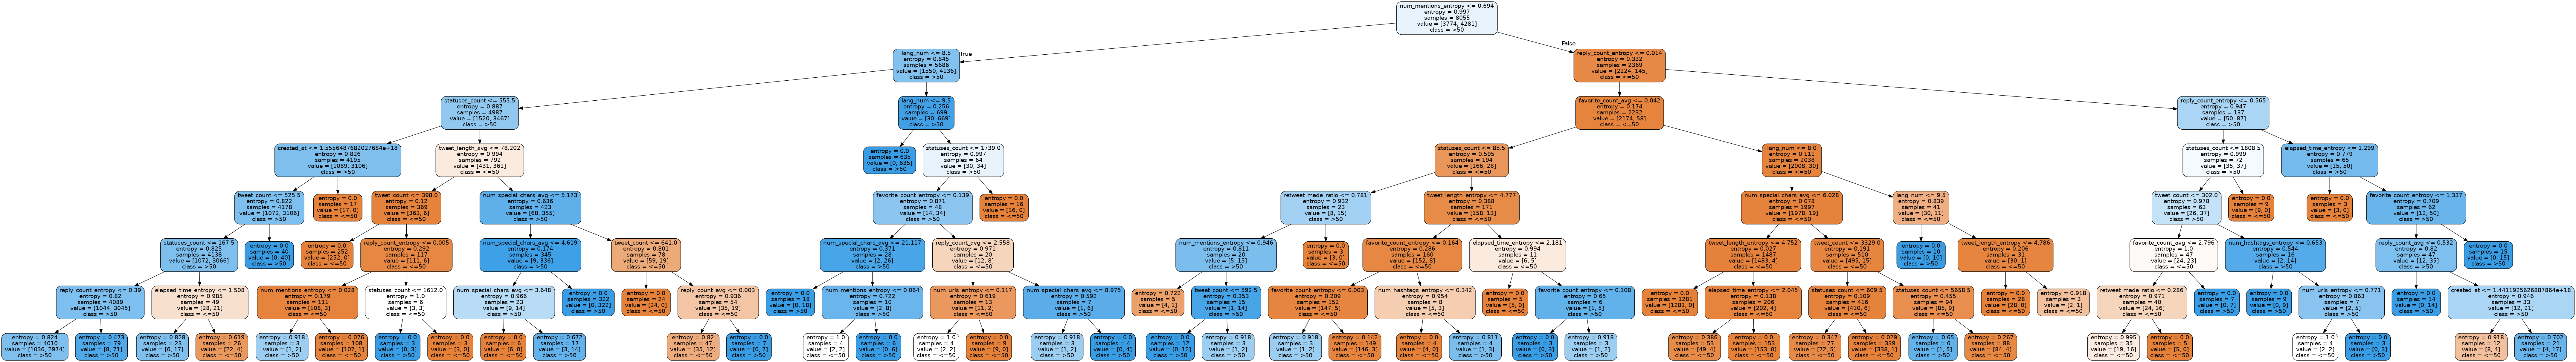

In [79]:
#visualize the actual decision tree obtained 
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['<=50', '>50'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [80]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

/home/dferraro/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/dferraro/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [86]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
print('Accuracy train set', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set 0.8602110490378647
Accuracy test set 0.8412974225311324
Precision train set 0.8824819696232904
Recall train set 0.8602110490378647
F1 score train set 0.8568349573035741
Support train set (array([0.97763348, 0.79859928]), array([0.71807101, 0.9855174 ]), array([0.82798656, 0.88226683]), array([3774, 4281]))


In [82]:
#metrics computed on the test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

In [83]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

        <=50       0.96      0.69      0.80      1618
         >50       0.78      0.97      0.87      1835

    accuracy                           0.84      3453
   macro avg       0.87      0.83      0.84      3453
weighted avg       0.86      0.84      0.84      3453



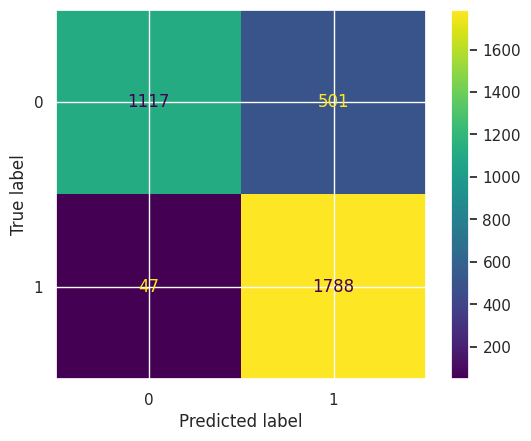

In [84]:
predictions = dt.predict(test_set.values)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

# Classification with Naive Bayes

In [126]:
scaler = StandardScaler()

train_set_std = scaler.fit_transform(train_set.values)
test_set_std = scaler.transform(test_set.values)

In [127]:
gnb = GaussianNB()
gnb.fit(train_set_std, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set_std)
train_pred_gnb = gnb.predict(train_set_std)

In [128]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
print('Accuracy train set', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set 0.8602110490378647
Accuracy test set 0.8412974225311324
Precision train set 0.8824819696232904
Recall train set 0.8602110490378647
F1 score train set 0.8568349573035741
Support train set (array([0.97763348, 0.79859928]), array([0.71807101, 0.9855174 ]), array([0.82798656, 0.88226683]), array([3774, 4281]))


In [129]:
#compute the performance of the model
report_scores(test_label, test_pred_gnb)

              precision    recall  f1-score   support

        <=50       0.86      0.62      0.72      1618
         >50       0.73      0.91      0.81      1835

    accuracy                           0.77      3453
   macro avg       0.79      0.76      0.76      3453
weighted avg       0.79      0.77      0.77      3453



In [134]:
# cross validation
scores = cross_validate(gnb, train_set_std, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.00828401247660319
Score time  0.0035828749338785806
Test score  0.7666045934202359
Train score  0.7679081315952825


# Classification with Random Forest

In [94]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [99]:
#define the parameters' values you want to try
params = {  "max_depth": [2, 3, 5, 6, 7, 10, 12, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False],
            "criterion": ["entropy", "gini"],
         }

#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(
    clf, 
    param_distributions=params, 
    n_iter=100, #define the number of iters
    cv = 3,
    verbose=1,
    n_jobs=-1, 
    scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)
print("The best parameters are", grid_search.best_params_, ", score: %0.5f" % (grid_search.best_score_))
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], grid_search.cv_results_['std_test_score'][0])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best parameters are {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True} , score: 0.85053
Mean and std of this setting  0.8464307883302297 0.0033496555091823777


In [100]:
rf = grid_search.best_estimator_

In [101]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)
train_pred_rf = rf.predict(train_set)

In [103]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
print('Accuracy train set', metrics.accuracy_score(train_label, train_pred_rf))
print('Accuracy test set', metrics.accuracy_score(test_label, test_pred_rf))
print('Precision train set', metrics.precision_score(train_label, train_pred_rf, average='weighted'))
print('Recall train set', metrics.recall_score(train_label, train_pred_rf, average='weighted'))
print('F1 score train set', metrics.f1_score(train_label, train_pred_rf, average='weighted'))
print('Support train set', metrics.precision_recall_fscore_support(train_label, train_pred_rf))

Accuracy train set 0.8693978895096214
Accuracy test set 0.8485375036200405
Precision train set 0.8924579913787417
Recall train set 0.8693978895096214
F1 score train set 0.8662436723653285
Support train set (array([0.99098124, 0.80560288]), array([0.72787493, 0.99416024]), array([0.83929117, 0.89000418]), array([3774, 4281]))


In [102]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

        <=50       0.97      0.70      0.81      1618
         >50       0.79      0.98      0.87      1835

    accuracy                           0.85      3453
   macro avg       0.88      0.84      0.84      3453
weighted avg       0.87      0.85      0.84      3453



/home/dferraro/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


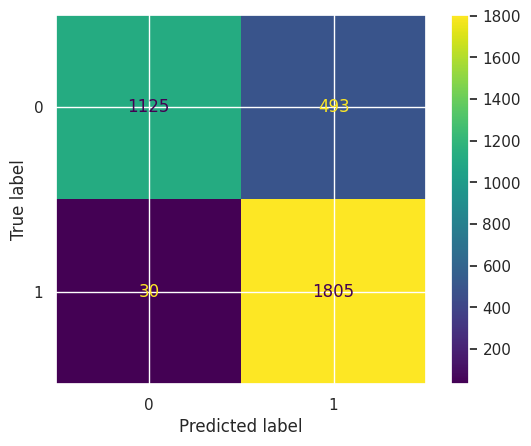

In [104]:
predictions = rf.predict(test_set.values)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

# AdaBoost

# ROC curve

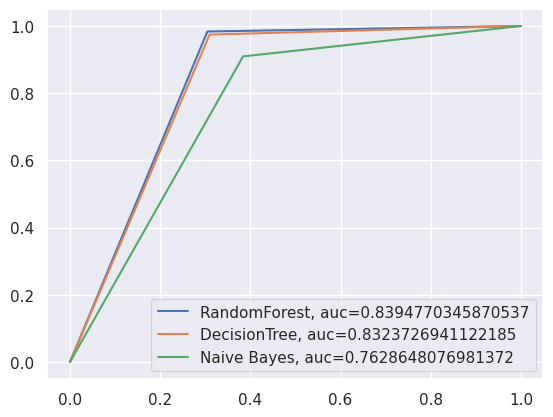

In [135]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

#fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_clf)
#auc = metrics.roc_auc_score(test_label, test_pred_clf)
#plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="Decision Tree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

plt.legend(loc=0)

# Classification with KNN

# Classification with SVM

# Classification with rule based

# Classification with neural network